In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
import pandas_datareader as pdr

from scipy import stats

import warnings
warnings.simplefilter('ignore')

# Load Data

- AAPL: Tech
- JPM: Finance
- JNJ: Health Care
- KO: Consumer Staples

$$ r_t = \frac{p_t - p_{t-1}}{p_{t-1}} $$

In [2]:
assets = ['AAPL', 'JPM','JNJ','KO']
price = yf.download(assets)['Adj Close']
price = price.dropna(axis=0, how='any')

rtns = price.pct_change().iloc[1:]

mkt = yf.download('^GSPC')['Adj Close']
mkt_rtn = mkt.pct_change().iloc[1:].loc[rtns.index]

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


# EDA

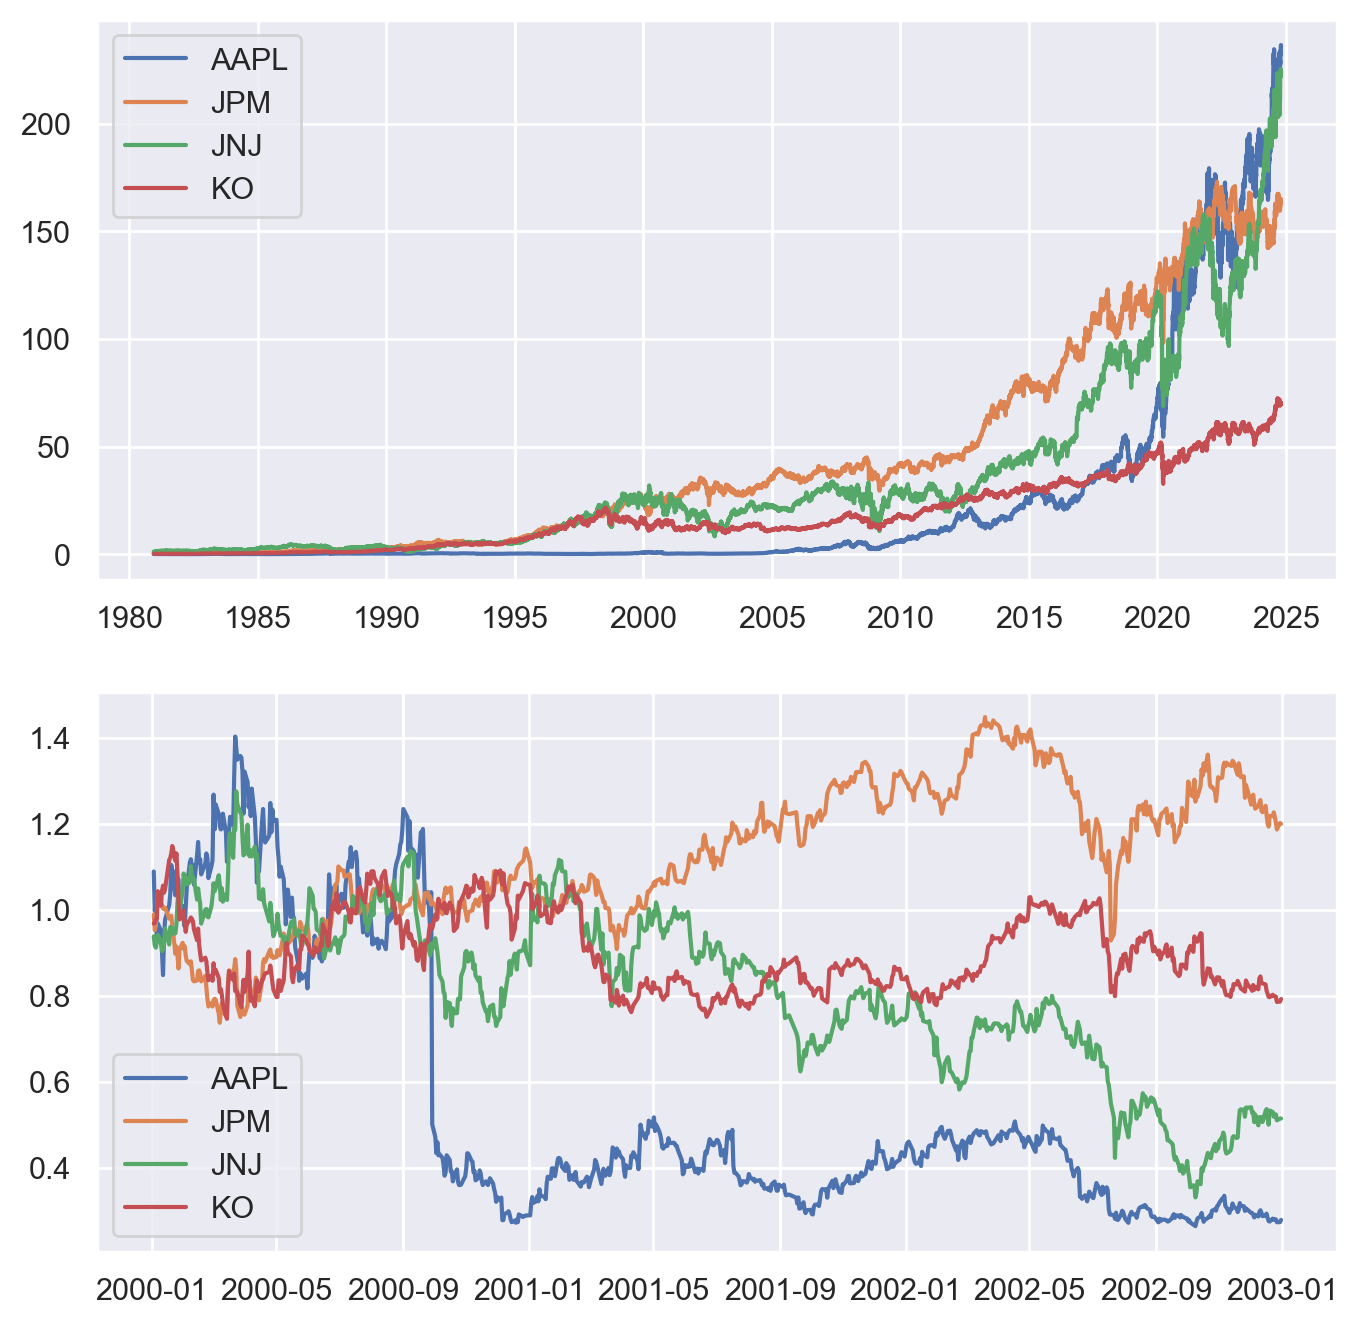

In [3]:
plt.figure(figsize=(8,8)) # 전체 canvas 사이즈를 가로 8 세로 8
plt.subplot(2, 1, 1) # 
plt.plot(price,label=assets)
plt.legend()
plt.subplot(2, 1, 2)
plt.plot((rtns.loc['2000':'2002'] + 1).cumprod(), label=assets)
plt.legend()
plt.show()

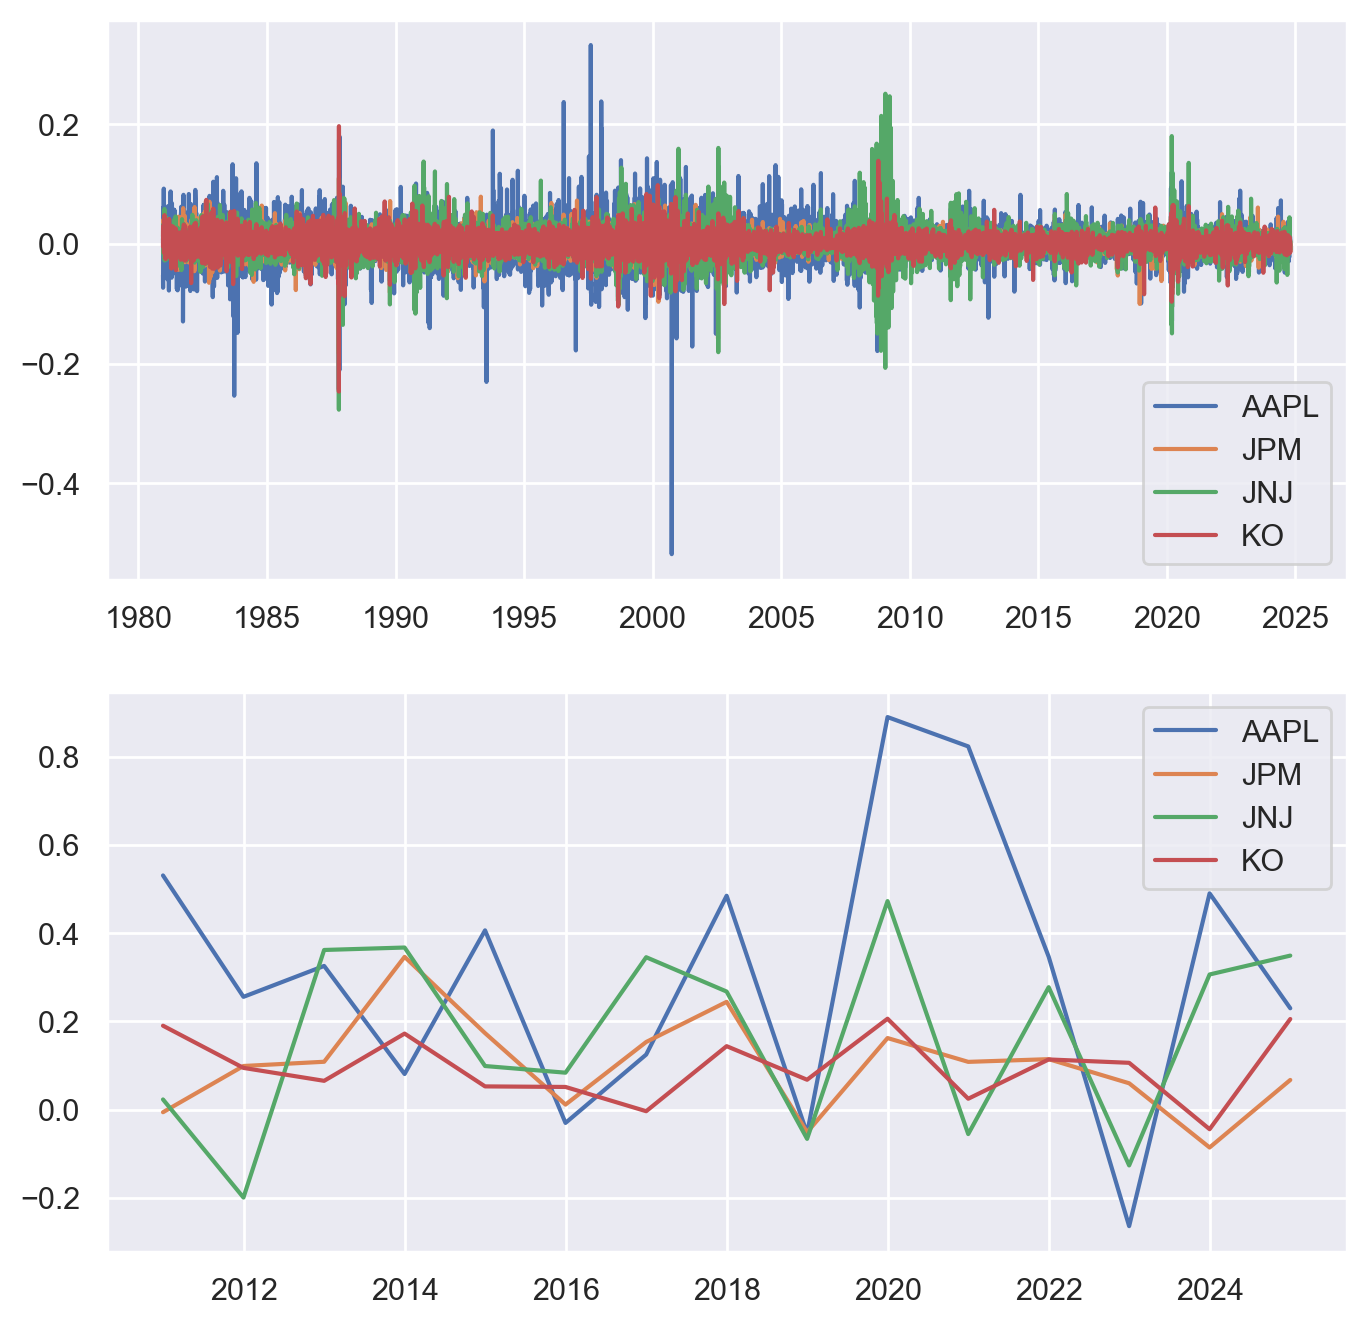

In [4]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1) 
plt.plot(rtns,label=assets)
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(rtns.loc['2010':].resample('Y').apply(lambda x:(1+x).prod()-1), label=assets)
plt.legend()
plt.show()

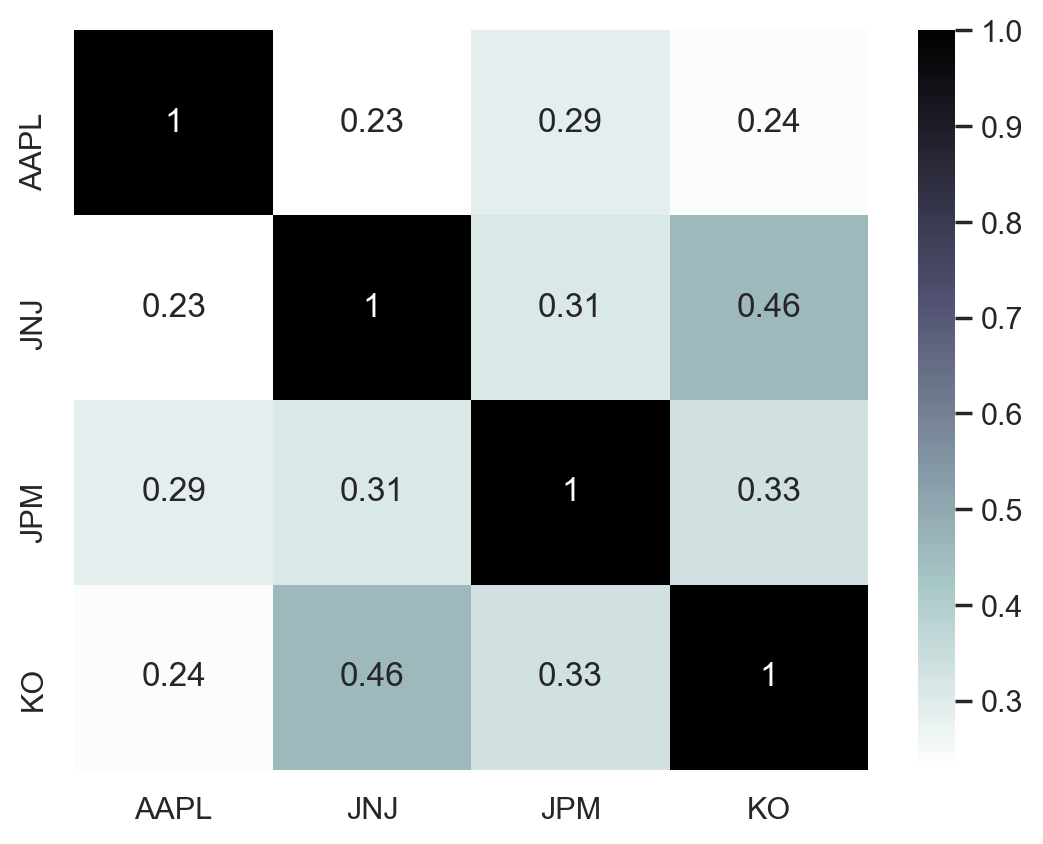

In [5]:
sns.heatmap(rtns.corr(), cmap='bone_r', annot=True)
plt.show()

In [6]:
# 평균
avg = rtns.mean() * 252
# 표준편차
vol = rtns.std(ddof=1) * np.sqrt(252)
# 왜도
sk = rtns.skew()
# 첨도
kt = rtns.kurtosis()
# 승률
wr = (rtns > 0).mean()
# min 
mn = rtns.min()
# max
mx = rtns.max()

rtns_desc = pd.concat([avg, vol, sk, kt, wr, mn, mx], axis=1)
rtns_desc.columns = ['Mean','Vol','Skew','Kurt','Win Rate','Min','Max']
rtns_desc

,Mean,Vol,Skew,Kurt,Win Rate,Min,Max
AAPL,0.276598,0.441883,-0.374789,18.502409,0.498734,-0.518692,0.332280
JNJ,0.150805,0.224721,-0.138773,7.980641,0.499186,-0.183544,0.122292
JPM,0.181562,0.354166,0.443397,14.311612,0.489508,-0.277193,0.250967
KO,0.161659,0.231316,-0.105589,15.864542,0.502442,-0.246914,0.196722


In [7]:
def calc_beta(r, mkt):
    beta = np.cov(r, mkt, ddof=1)[0, 1] / np.var(mkt, ddof=1)
    return beta

In [8]:
betas = rtns.apply(lambda x: calc_beta(x, mkt_rtn))
print(betas)

AAPL    1.215702
JNJ     0.695109
JPM     1.328730
KO      0.726019
dtype: float64


# Probability Distribution

|Type|Class|Prob Dist|
|------|------|------|
|Discrete|bernoulli|베르누이|
|Discrete|binom|이항|
|Continuous|uniform|균등|
|Continuous|norm|정규|
|Continuous|beta|베타|
|Continuous|t|스튜던트t|

## Fitting

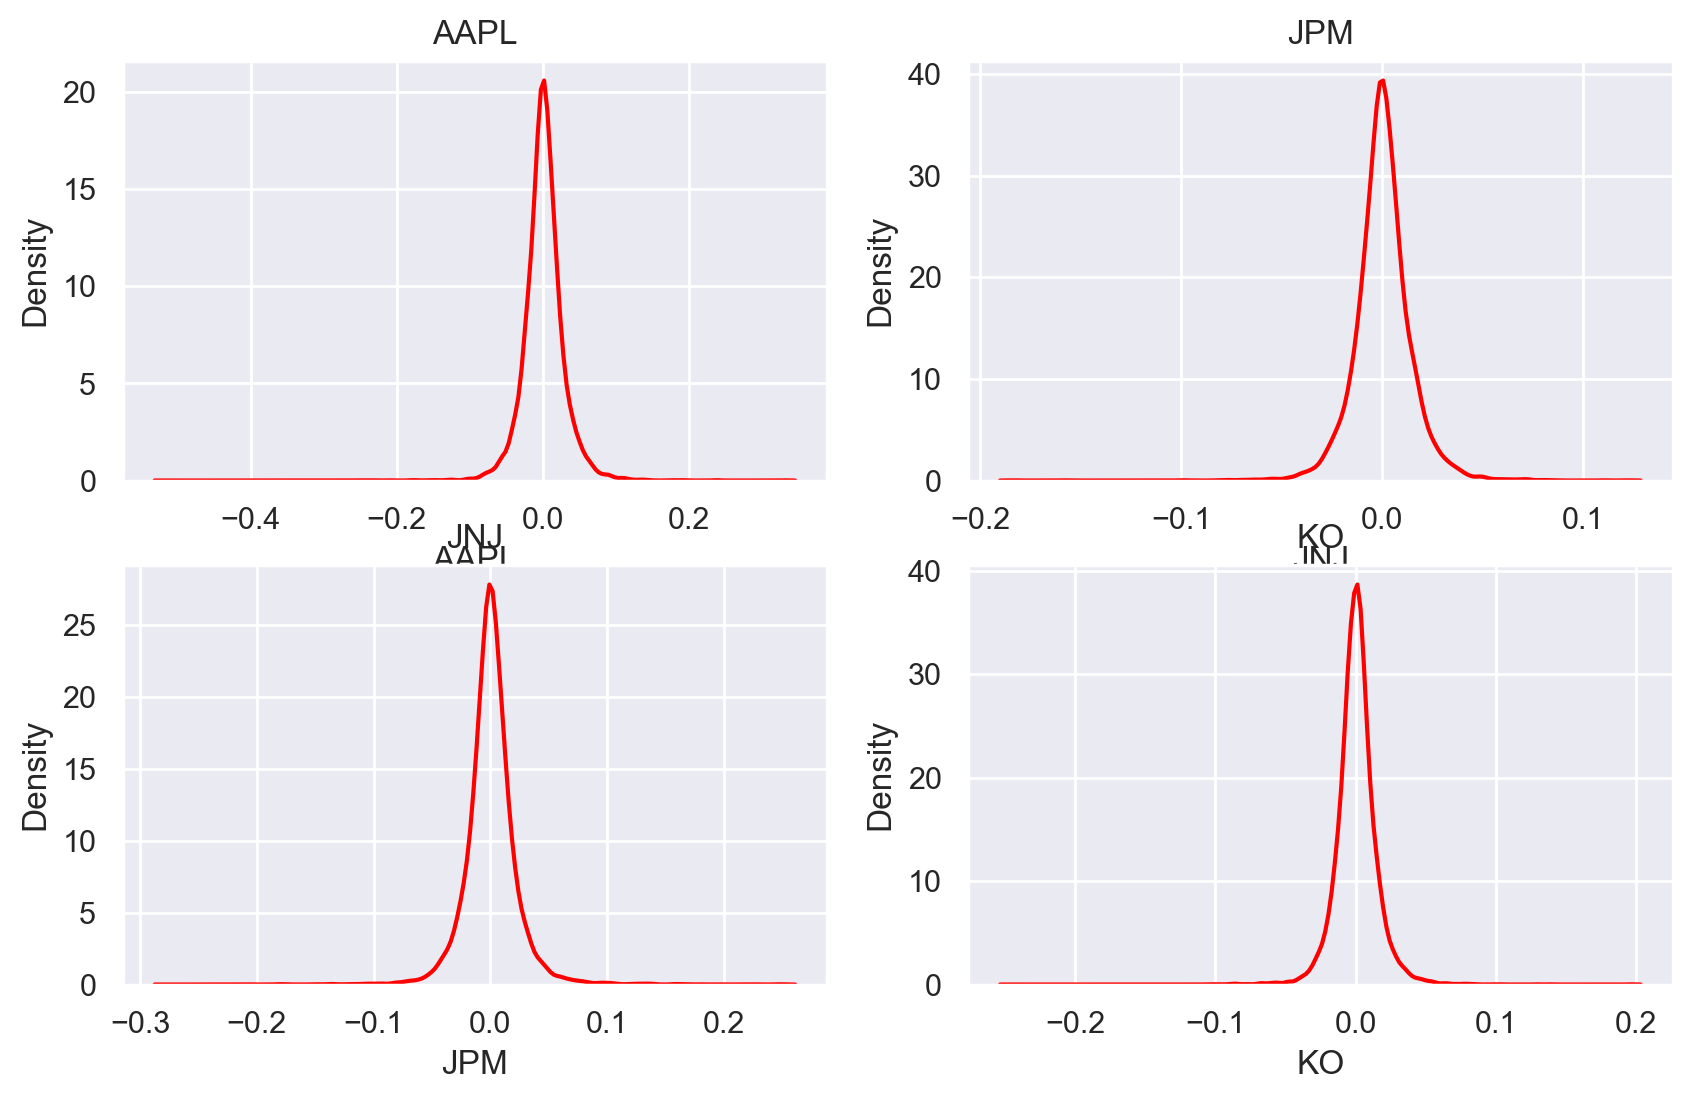

In [9]:
plt.figure(figsize=(10,6))
for i in range(len(assets)):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(rtns.iloc[:, i], color='red')
    plt.title(assets[i])
plt.show()

In [10]:
# shapiro wilk test (H0: it follows normal)
stat, p = stats.shapiro(rtns['AAPL'])
print('test statistic:', stat)
print('p value:', p)

test statistic: 0.9172812700271606
p value: 0.0


$$ l(\theta) = log L(\theta) = log f_\theta (x) = log \prod_{i=1}^n f(x|\theta_i) = \Sigma_{i=1}^n log f(x|\theta_i) $$

In [11]:
dist = stats.norm
param = dist.fit(rtns['AAPL'])
ll = np.sum(dist.logpdf(rtns['AAPL'], *param))
aic = 2 * len(param) - 2 * ll
print(aic)

-47813.91777184297


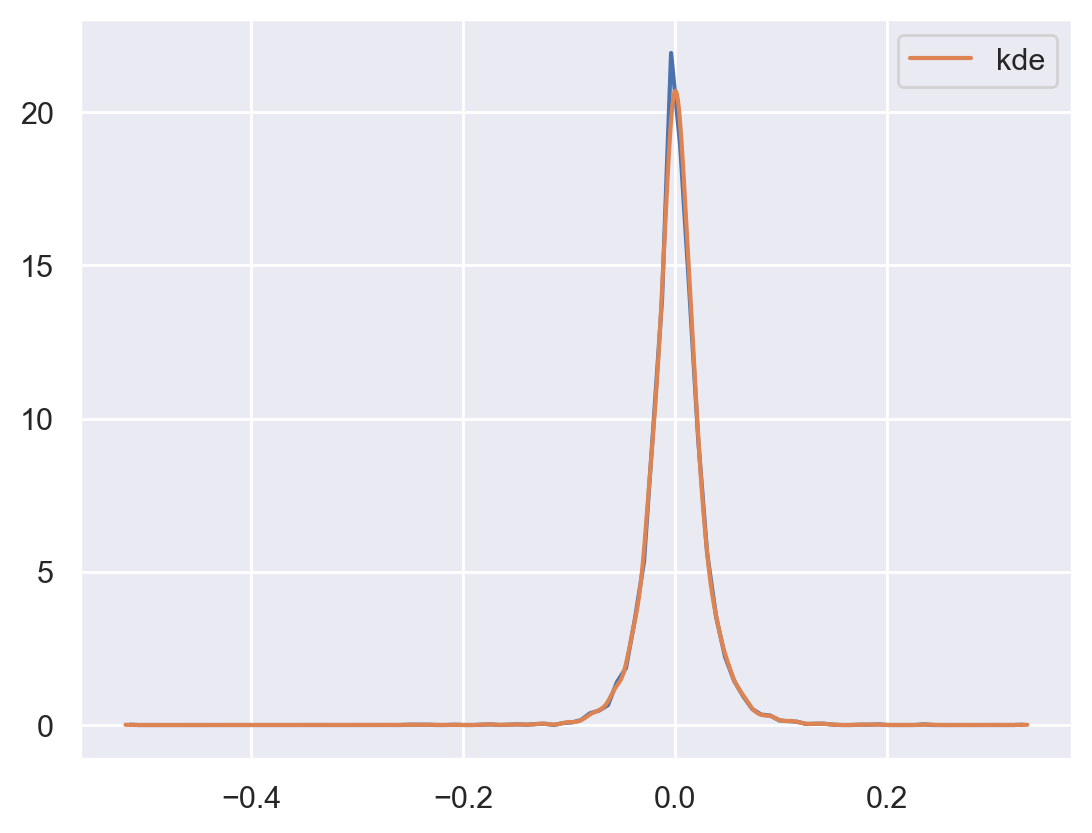

In [12]:
kde = stats.gaussian_kde(rtns['AAPL'])
X = np.linspace(rtns['AAPL'].min(), rtns['AAPL'].max(), 1000)
K = kde(X)

y, x = np.histogram(rtns['AAPL'], bins=100, density=True)
x = [(j + x[i+1])/2.0 for i,j in enumerate(x[:-1])]

plt.plot(x, y)
plt.plot(X, K, label='kde')
plt.legend()
plt.show()

## 시나리오 분석

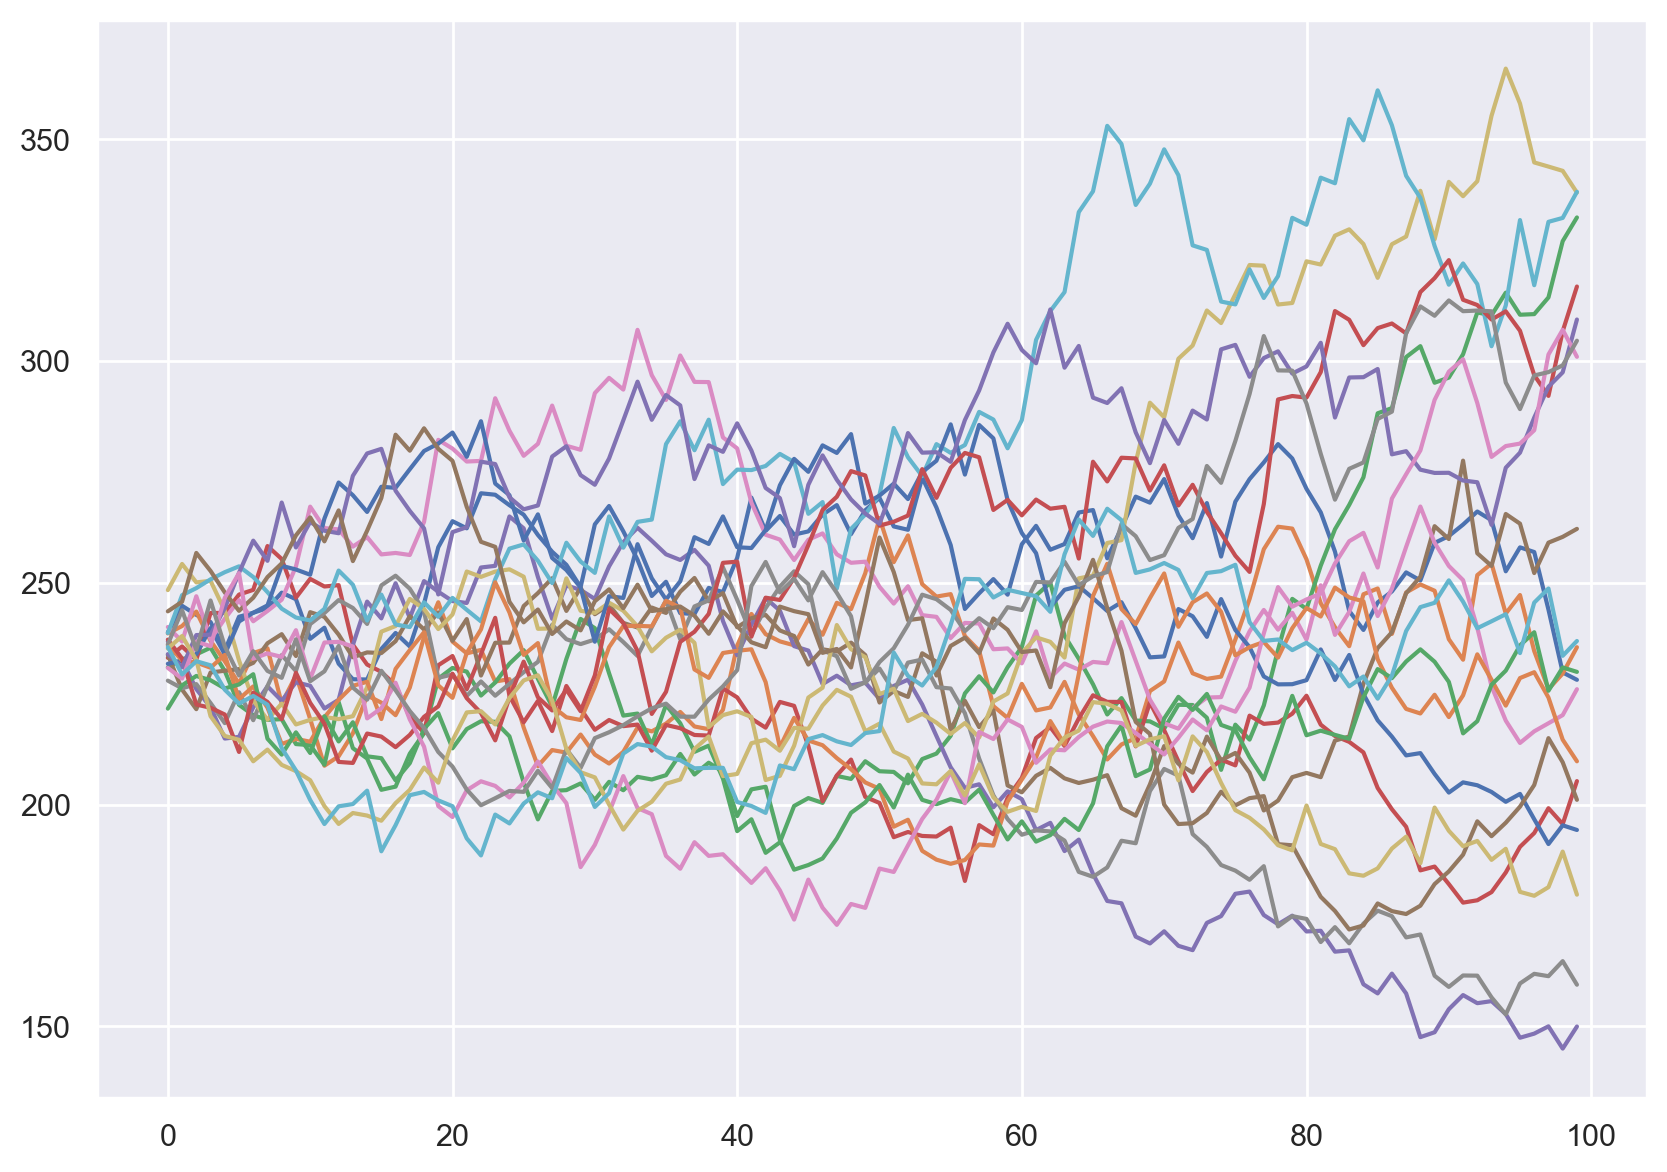

In [13]:
def random_walk(price, mean, vol, n_iter):
    ls = []
    last_price = price[-1]
    for i in range(n_iter):
        last_price = last_price + last_price * np.random.normal(mean, vol)
        ls.append(last_price)
    return np.array(ls)

n_iter = 100
plt.figure(figsize=(10,7))
# sim_mean = []
for _ in range(20):
    sim_prices = random_walk(price['AAPL'].values, rtns['AAPL'].mean(), rtns['AAPL'].std(), n_iter)
    plt.plot(range(n_iter), sim_prices)
    # sim_mean.append(np.log(pd.Series(sim_prices) / pd.Series(sim_prices).shift(1)).fillna(0).mean())
plt.show()    

## 위험 분석

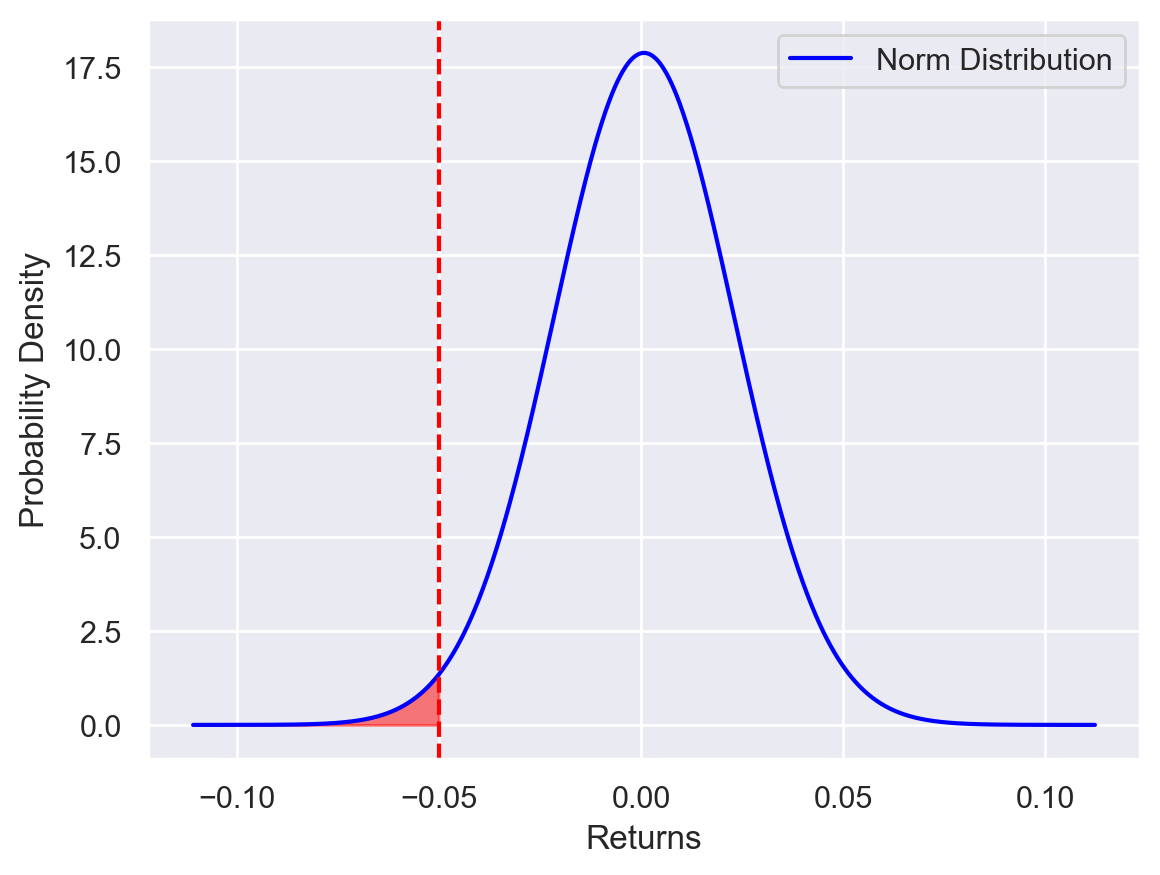

In [14]:
mu = rtns['JPM'].mean()
sigma = rtns['JPM'].std()

x = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 1000)
y = stats.norm.pdf(x, mu, sigma)  # ~ N(mu, sigma)
value = -0.05

plt.plot(x, y, label='Norm Distribution', color='blue')
plt.axvline(value, color='red', linestyle='--')
plt.fill_between(x, 0 , y, where= (x <= value), color='red', alpha=0.5)
plt.xlabel('Returns')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [15]:
# Value-at-Risk 

confidence_level = 0.95

dist = stats.norm
param = dist.fit(rtns['JPM'])

x = dist.ppf(1 - confidence_level, *param)
print(x * 100)

-3.597515139123411


# Regression

## 가격예측

In [16]:
train_X = sm.add_constant(mkt.shift(1).loc['2000':'2020'])
train_y = mkt.loc['2000':'2020']

ols = sm.OLS(train_y, train_X)
fitted = ols.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.552e+06
Date:                Wed, 23 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:09:21   Log-Likelihood:                -23532.
No. Observations:                5284   AIC:                         4.707e+04
Df Residuals:                    5282   BIC:                         4.708e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2920      0.758     -0.385      0.7

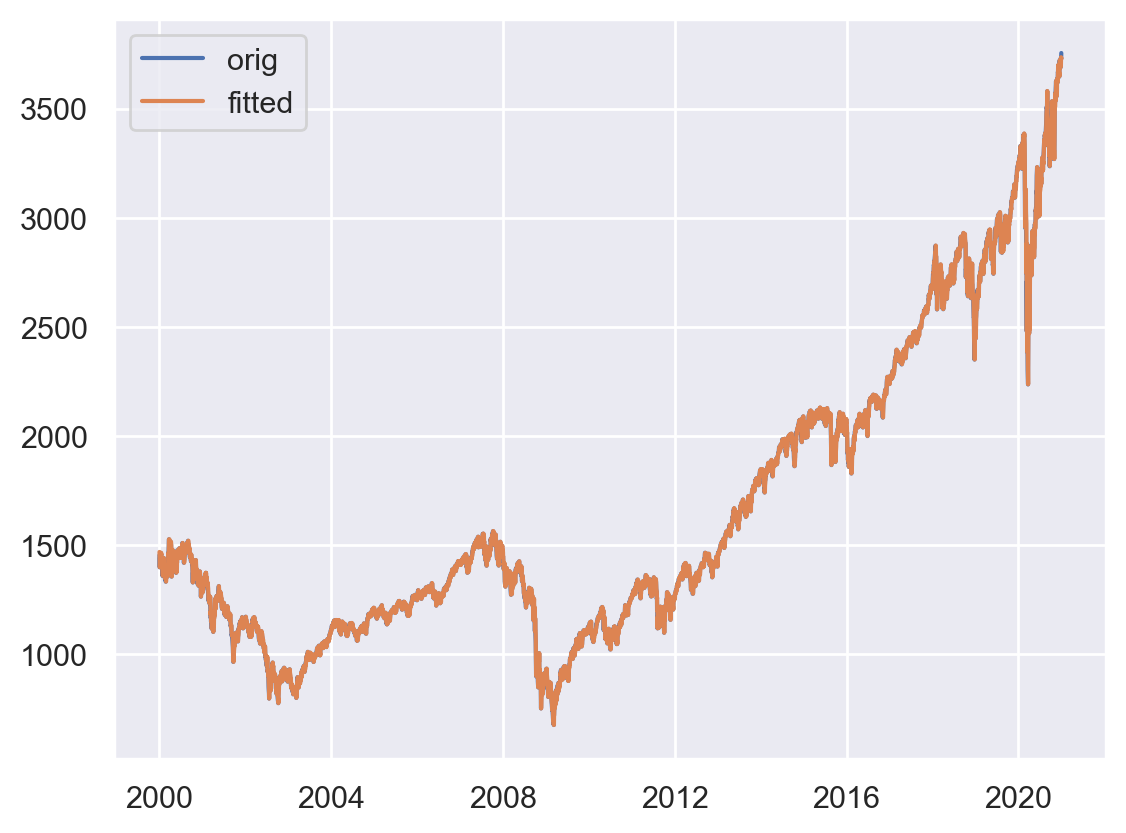

In [17]:
fitted_y = fitted.fittedvalues
plt.plot(train_y, label='orig')
plt.plot(fitted_y, label='fitted')
plt.legend()
plt.show()

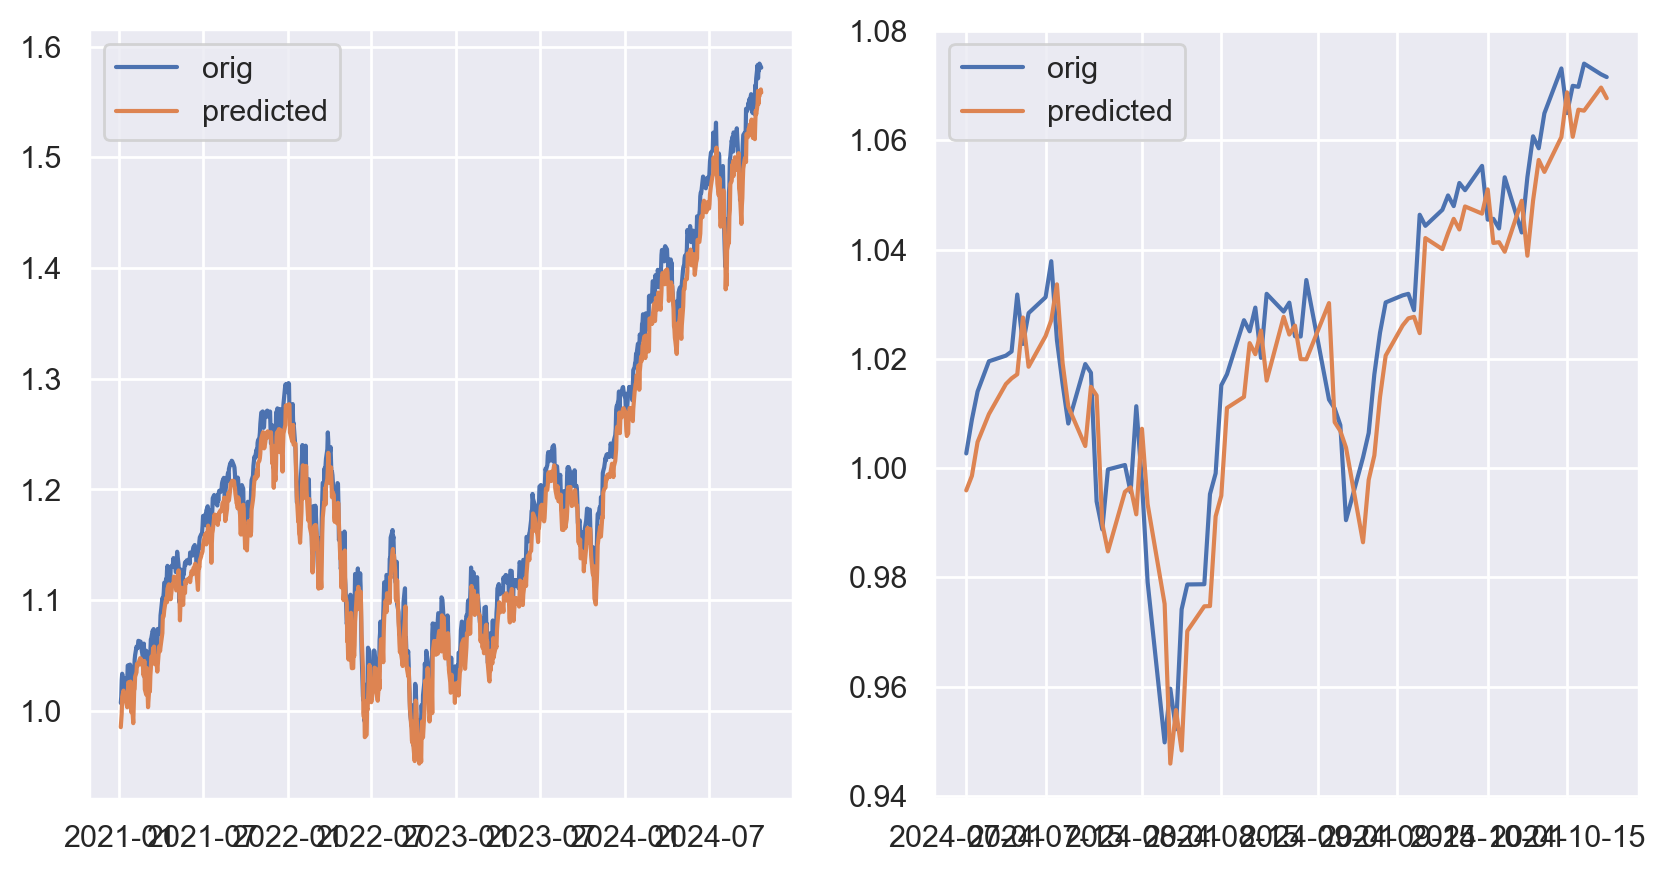

In [18]:
test_X = sm.add_constant(mkt.shift(1).loc['2021':"2024"])
test_y = mkt.loc['2021':'2024']

pred_y  = fitted.predict(test_X)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot((test_y.pct_change() + 1).cumprod(), label='orig')
plt.plot((pred_y.pct_change() + 1).cumprod(), label='predicted')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot((test_y.pct_change().loc['2024-7':] + 1).cumprod(), label='orig')
plt.plot((pred_y.pct_change().loc['2024-7':]  + 1).cumprod(), label='predicted')
plt.legend()
plt.show()


## 수익률 예측

In [19]:
train_X = sm.add_constant(mkt_rtn.shift(1).loc['2000':'2020'])
train_y = mkt_rtn.loc['2000':'2020']

ols = sm.OLS(train_y, train_X)
fitted = ols.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     70.26
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           6.60e-17
Time:                        12:09:23   Log-Likelihood:                 15679.
No. Observations:                5284   AIC:                        -3.135e+04
Df Residuals:                    5282   BIC:                        -3.134e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.667      0.0

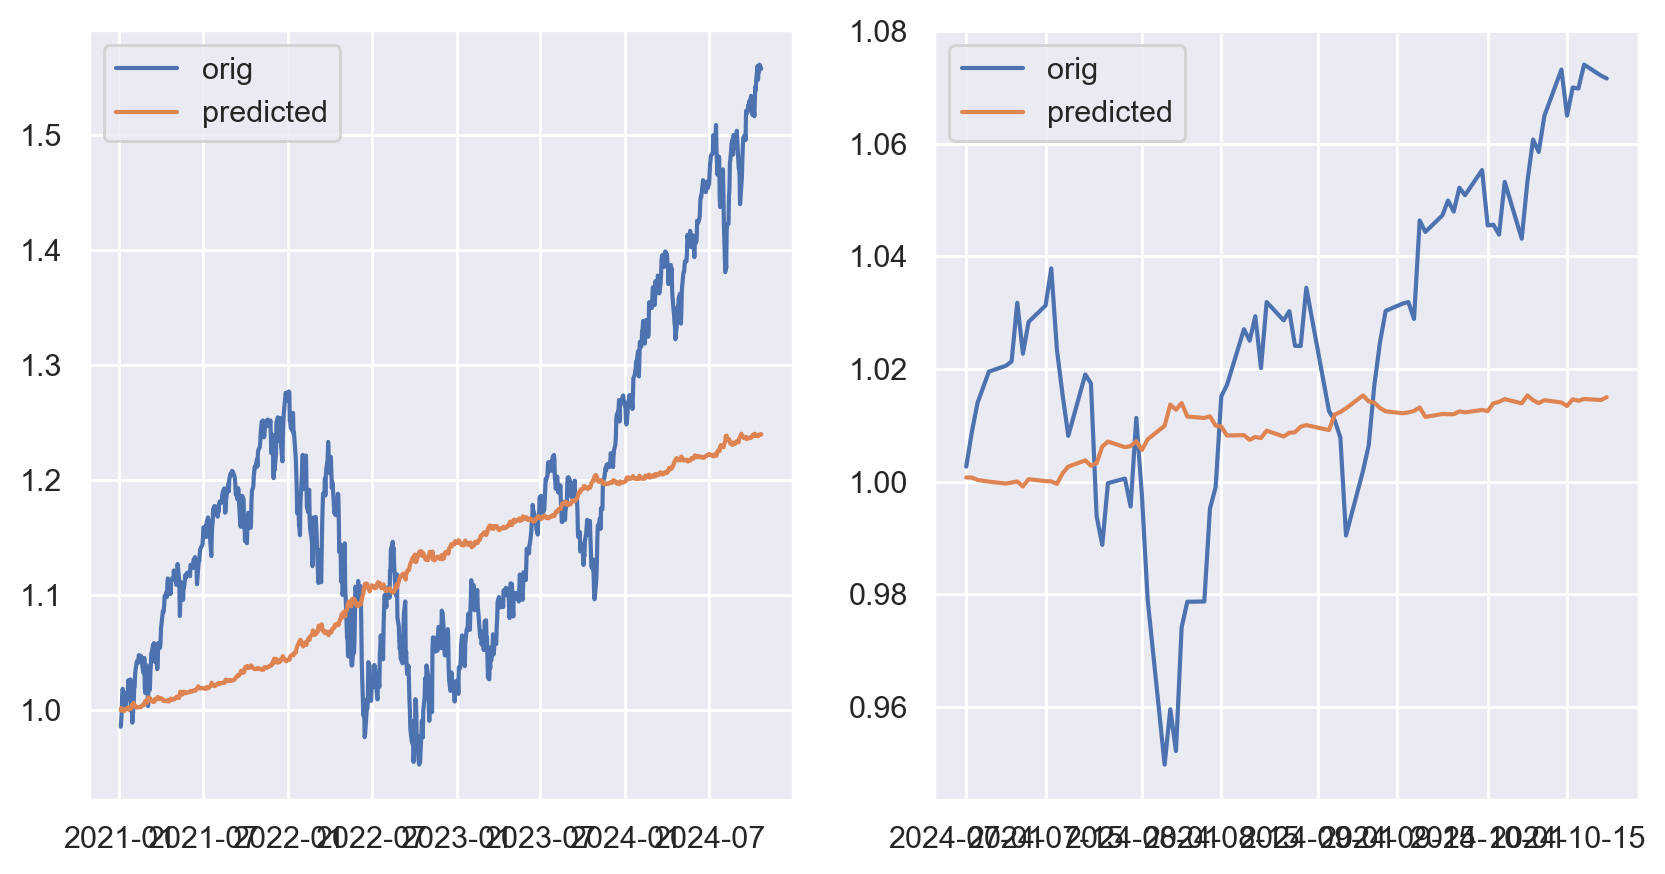

In [20]:
test_X = sm.add_constant(mkt_rtn.shift(1).loc['2021':"2024"])
test_y = mkt_rtn.loc['2021':'2024']

pred_y  = fitted.predict(test_X)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot((test_y + 1).cumprod(), label='orig')
plt.plot((pred_y + 1).cumprod(), label='predicted')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot((test_y.loc['2024-7':] + 1).cumprod(), label='orig')
plt.plot((pred_y.loc['2024-7':]  + 1).cumprod(), label='predicted')
plt.legend()
plt.show()

## 분석

$$ E[R_p] = R_f + \beta(E[R_M] - R_f) $$

- $E[R_p]$ : 포트폴리오 기대수익률
- $R_f$ : 무위험 수익률
- $E[R_M]$ : 시장 기대수익률 (Index 사용)
- $\beta$ : 베타

$$ \beta_p = \frac{Cov(R_p - R_f, R_M - R_f)}{Var(R_M - R_f)} $$

- $\beta_p$ 에 대한 가장 간단한 Estimate : Linear Regression을 활용하는 것

$$ r_P = \alpha_P + \beta_P r_M + \epsilon_P $$
- $r_P$ : 포트폴리오 초과 수익률
- $r_M$ : 시장 초과 수익률 

- $\beta$ 를 추정하는 방법은 여러가지가 있습니다.
    - Bayesian

$$ r_P = \beta_P r_M + \epsilon_P $$

- $Cov(\epsilon_P, r_M)$ = 0 이므로,

$$ Var(r_P) = \sigma^2_P = \beta^2_P \sigma^2_M + Var(\epsilon_P) $$

- $E[\epsilon_p] = 0 $
- $ E[r_p] = \mu_P = \beta_P E[r_M] $

- 1 factor (CAPM) : Market Premimum
- 3 factor : Market Premimum, SMB, HML(value)
- 5 factor : Market Premimum, SMB, HML, RMW(수익성), CMA(투자)

In [21]:
print(pdr.famafrench.get_available_datasets()[:10])

['F-F_Research_Data_Factors', 'F-F_Research_Data_Factors_weekly', 'F-F_Research_Data_Factors_daily', 'F-F_Research_Data_5_Factors_2x3', 'F-F_Research_Data_5_Factors_2x3_daily', 'Portfolios_Formed_on_ME', 'Portfolios_Formed_on_ME_Wout_Div', 'Portfolios_Formed_on_ME_Daily', 'Portfolios_Formed_on_BE-ME', 'Portfolios_Formed_on_BE-ME_Wout_Div']


In [28]:
start = pd.to_datetime('1980-1-1')
ff3 = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors', freq='M', start=start).read()[0]
ff_mom = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor', freq='M', start=start).read()[0]
ff_mom.columns = ['MOM']

ff4 = pd.concat([ff3, ff_mom], axis=1) / 100
ff4.index = pd.to_datetime(ff4.index.strftime('%Y-%m-%d'))
ff4

,Mkt-RF,SMB,HML,RF,MOM
Date,,,,,
1980-01-31,0.0551,0.0162,0.0175,0.0080,0.0755
1980-02-29,-0.0122,-0.0185,0.0061,0.0089,0.0788
1980-03-31,-0.1290,-0.0664,-0.0101,0.0121,-0.0955
1980-04-30,0.0397,0.0105,0.0106,0.0126,-0.0043
1980-05-31,0.0526,0.0213,0.0038,0.0081,-0.0112
...,...,...,...,...,...
2024-04-30,-0.0467,-0.0239,-0.0052,0.0047,-0.0042
2024-05-31,0.0434,0.0078,-0.0166,0.0044,-0.0002
2024-06-30,0.0277,-0.0306,-0.0331,0.0041,0.0090


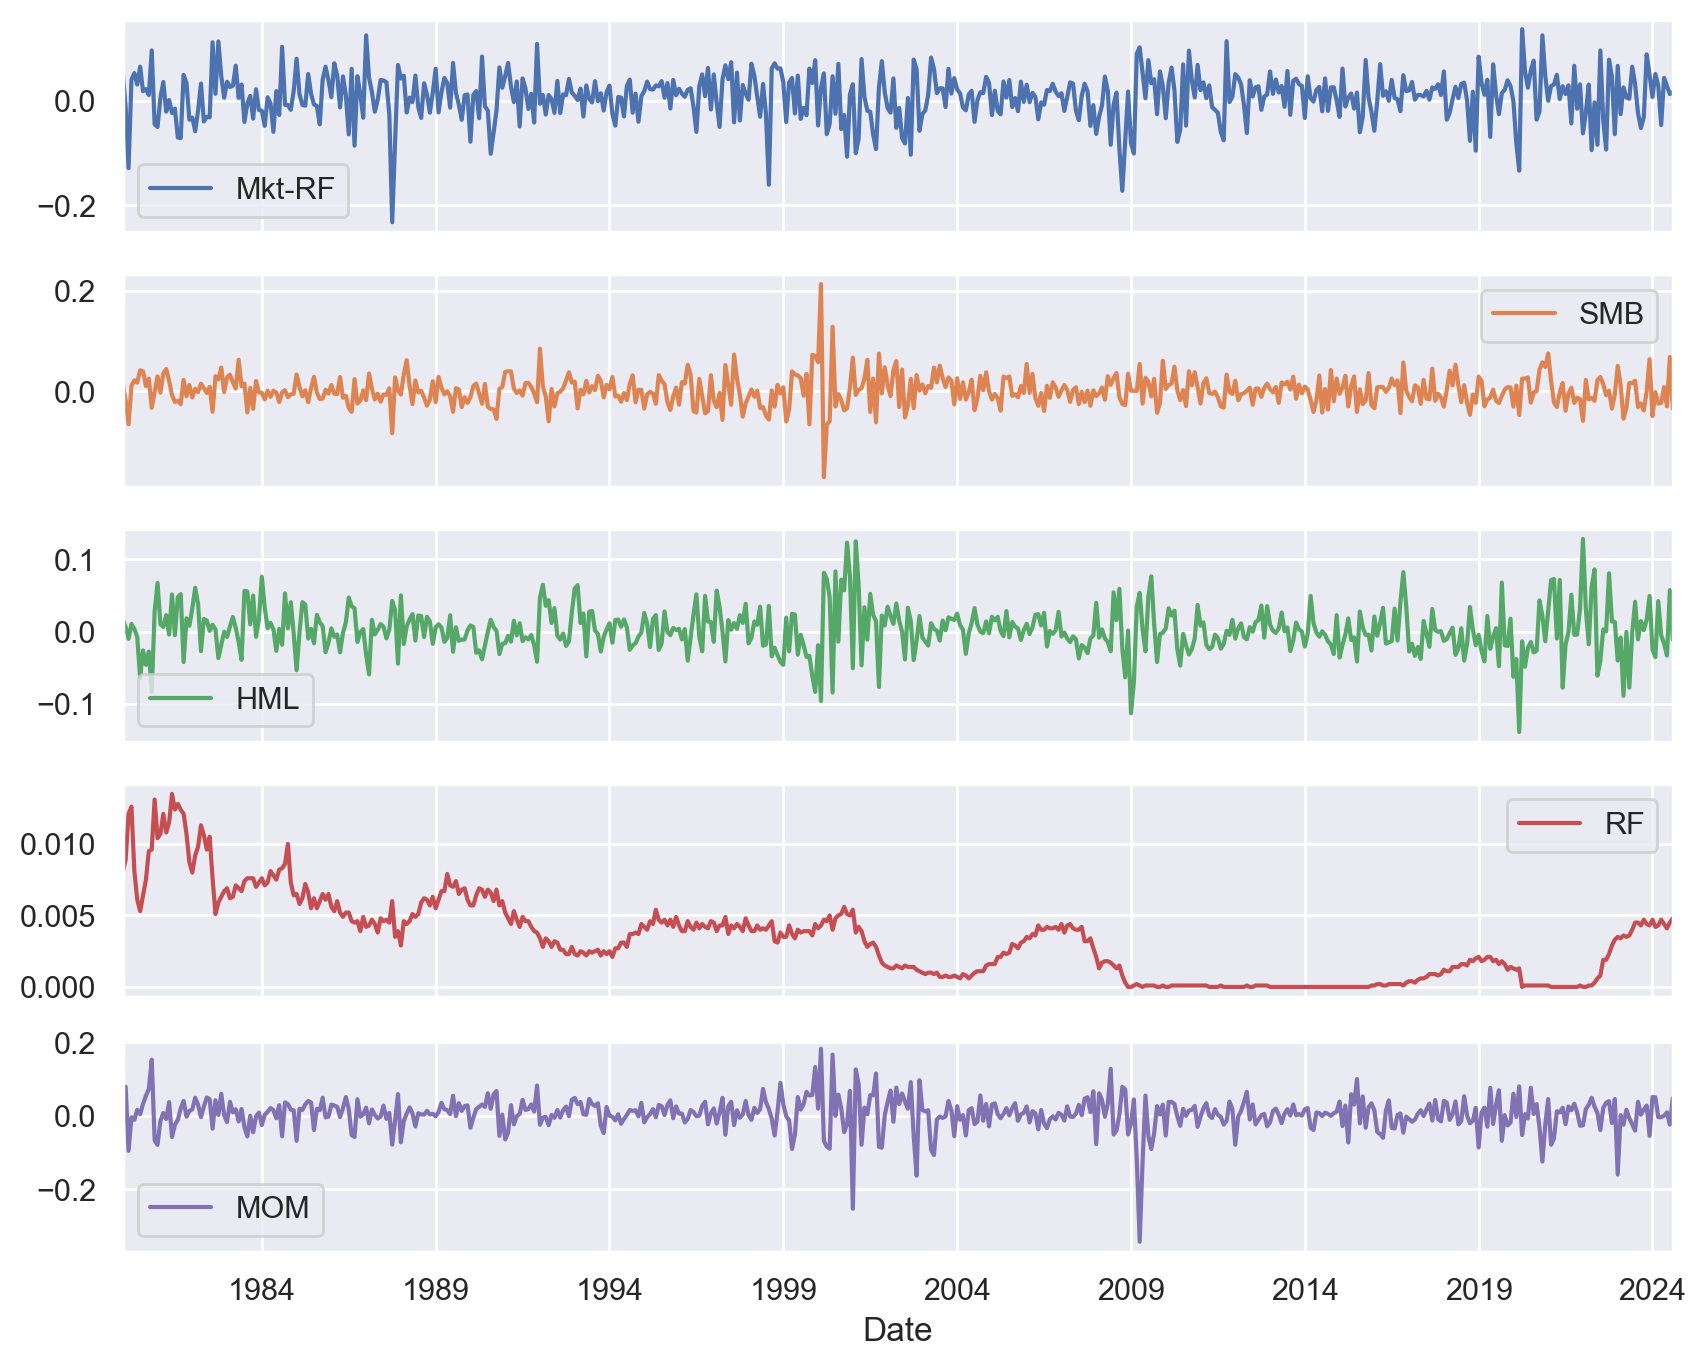

In [30]:
ff4.plot(subplots=True, figsize=(10,8))
plt.show()

In [31]:
rtns_m = rtns.resample('M').apply(lambda x: (1+x).prod() -1)

In [34]:
df_merged = pd.concat([ff4, rtns_m], axis=1).dropna()
ertns_m = df_merged.iloc[:, -4:] - df_merged[['RF']].values
factors = df_merged[['Mkt-RF','SMB','HML','MOM']]

In [35]:
X = sm.add_constant(factors)
y = ertns_m['KO']

ols = sm.OLS(y, X)
fitted = ols.fit()

print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                     KO   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     45.25
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           1.28e-32
Time:                        12:21:37   Log-Likelihood:                 833.22
No. Observations:                 525   AIC:                            -1656.
Df Residuals:                     520   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.002      2.195      0.0

-1.8820923655550272e-17


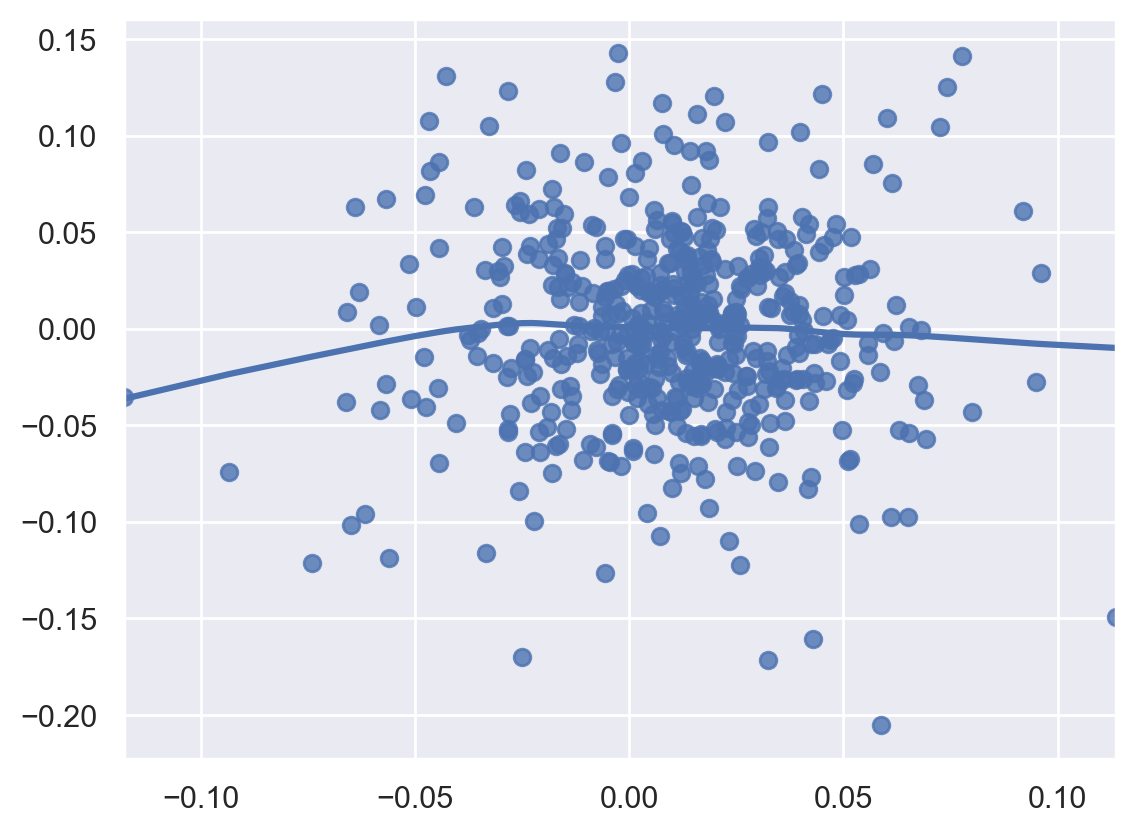

In [39]:
# 선형성 / 등분산성
resid = y - fitted.fittedvalues
print(resid.mean())
sns.regplot(x=fitted.fittedvalues, y=resid, lowess=True)
plt.show()

In [40]:
# H0: 모분산 일치
stat, p = stats.levene(fitted.fittedvalues, resid)
print("test stat:", stat)
print("p value:", p)

test stat: 92.39067573067666
p value: 5.081507327460759e-21


In [41]:
# 잔차 자기상관성 (1.5 ~ 2.5)
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     KO   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     45.25
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           1.28e-32
Time:                        12:28:51   Log-Likelihood:                 833.22
No. Observations:                 525   AIC:                            -1656.
Df Residuals:                     520   BIC:                            -1635.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.002      2.195      0.029       0.001       0.009
Mkt-RF         0.6683      0.052     12.873      0.000       0.566       0.770
SMB           -0.4360      0.075     -5.791      0.000      -0.584      -0.288
HML            0.0595      0.073      0.810      0.418      -0.085       0.204
MOM            0.0874      0.052      1.672      0.095      -0.015       0.190
==============================================================================
Omnibus:                       16.138   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.642
Skew:                          -0.165   Prob(JB):                     3.66e-07
Kurtosis:                       4.116   Cond. No.                         37.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

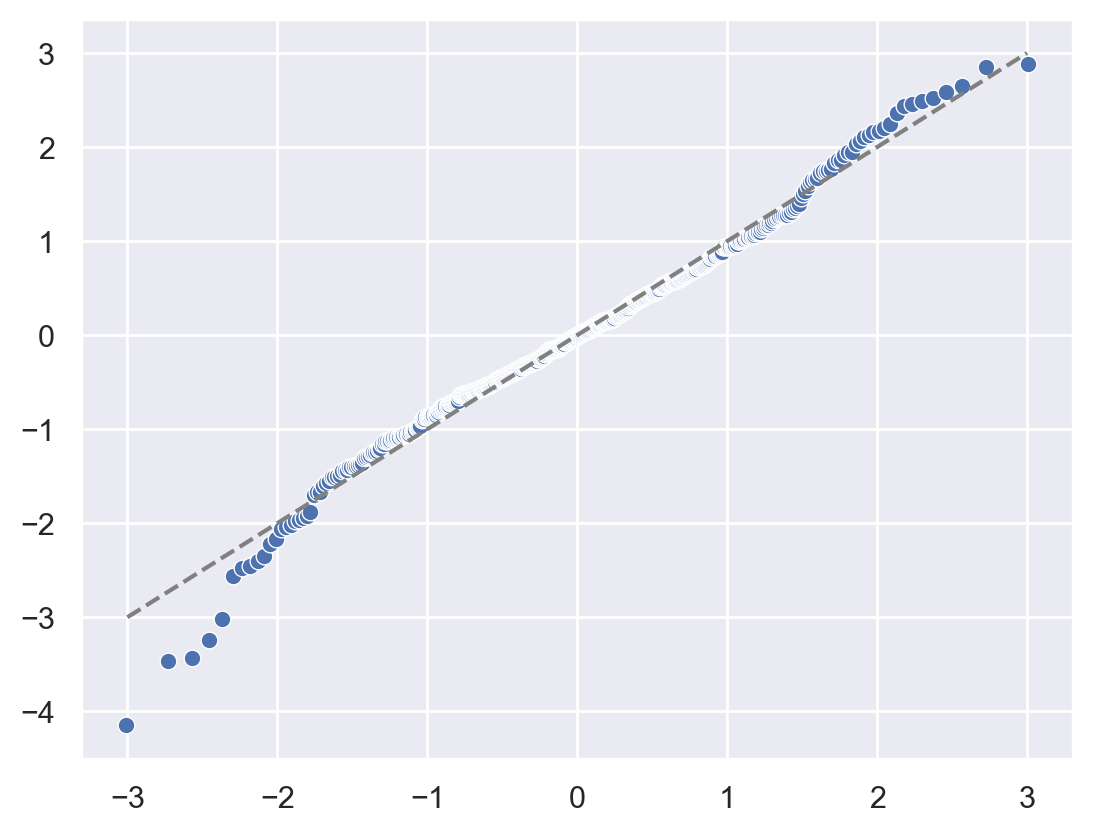

In [42]:
# 정규성
sr = stats.zscore(resid)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')
plt.show()

In [43]:
# H0: 정규분포를 따른다
norm_res = stats.shapiro(resid)
print(norm_res)

ShapiroResult(statistic=0.987064778804779, pvalue=0.0001318914000876248)


In [44]:
def ols_fit(y, X):
    X_ = sm.add_constant(X)
    ols = sm.OLS(y, X_)
    fitted = ols.fit()
    return fitted.params

In [45]:
res_fs = pd.concat([ols_fit(ertns_m[col], factors) for col in assets], axis=1)
res_fs.columns = assets
res_fs

,AAPL,JPM,JNJ,KO
const,0.014609,0.001298,0.003883,0.004922
Mkt-RF,1.182590,1.283310,0.719779,0.668333
SMB,0.240263,0.150107,-0.517276,-0.435985
HML,-0.885892,0.763878,-0.049804,0.059524
MOM,-0.129644,-0.260277,0.113665,0.087409
